In [2]:
#importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df_proceso = pd.read_csv('df_final_web_data.csv')

In [4]:
df_proceso.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [5]:
df = pd.read_csv('df_final.csv')

C:\Users\Propietario\AppData\Local\Temp\ipykernel_664\889013762.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_final.csv')


In [6]:
df.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,clnt_age_group
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test,Senior
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control,Senior
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test,Joven
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test,Adulto
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control,Joven


In [7]:
# Fusionaremos los df para tener un solo df con toda la información, haciendo un merge por la columna 'id'
df_final = pd.merge(df, df_proceso, on='client_id')


In [8]:
df_final['date_time'] = pd.to_datetime(df_final['date_time'])

In [9]:
df_final['date_time'].dtypes

dtype('<M8[ns]')

In [10]:
df_final.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,clnt_age_group,visitor_id,visit_id,process_step,date_time
0,836976,6.0,73.0,60.5,U,2.0,45105.3,6.0,9.0,Test,Senior,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13
1,836976,6.0,73.0,60.5,U,2.0,45105.3,6.0,9.0,Test,Senior,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:47:50
2,836976,6.0,73.0,60.5,U,2.0,45105.3,6.0,9.0,Test,Senior,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:46:45
3,836976,6.0,73.0,60.5,U,2.0,45105.3,6.0,9.0,Test,Senior,427070339_1413275162,228976764_46825473280_96584,step_3,2017-04-02 11:23:08
4,836976,6.0,73.0,60.5,U,2.0,45105.3,6.0,9.0,Test,Senior,427070339_1413275162,228976764_46825473280_96584,step_2,2017-04-02 11:22:24


In [11]:
#Borraremos la columna clnt_age_group ya que no la necesitamos.
if 'clnt_age_group' in df_final.columns:
	df_final = df_final.drop(columns=['clnt_age_group'])
if 'clnt_tenure_yr' in df_final.columns:
	df_final = df_final.drop(columns=['clnt_tenure_yr'])

In [13]:
# Asegúrate de que df_final_sorted esté definido antes de usarlo
df_final_sorted = df_final.sort_values(by=['client_id', 'date_time'])
df_final_sorted['time_diff'] = df_final_sorted.groupby('client_id')['date_time'].diff().dt.total_seconds() / 60.0

# Definir las columnas relevantes para eliminar outliers
columns_to_check = ['clnt_tenure_mnth', 'clnt_age', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'time_diff']

# Eliminar outliers usando el método IQR
for column in columns_to_check:
    q1 = df_final_sorted[column].quantile(0.25)
    q3 = df_final_sorted[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_final_sorted = df_final_sorted[(df_final_sorted[column] >= lower_bound) & (df_final_sorted[column] <= upper_bound)]

In [14]:
df_final['Variation'].unique()

array(['Test', 'Control', nan], dtype=object)

In [15]:
# en la columna Variation, eliminaremos los nulos
df_final = df_final.dropna(subset=['Variation'])

KPI (Indicadores clave de rendimiento)

In [16]:
# Identificar usuarios que han completado el proceso (confirm) y aquellos que no lo han hecho
usuarios_completaron_test = df_final[(df_final['Variation'] == 'Test') & (df_final['process_step'] == 'confirm')]['client_id'].unique()
usuarios_completaron_control = df_final[(df_final['Variation'] == 'Control') & (df_final['process_step'] == 'confirm')]['client_id'].unique()

In [17]:
print("Usuarios que completaron el proceso (Test):", len(usuarios_completaron_test))
print("Usuarios que completaron el proceso (Control):", len(usuarios_completaron_control))

Usuarios que completaron el proceso (Test): 18687
Usuarios que completaron el proceso (Control): 15434


### Tasa de finalización : la proporción de usuarios que llegan al paso final de "confirmación".

Usuarios que completaron el proceso (Test): 18687
Usuarios que completaron el proceso (Control): 15434

In [18]:
# Identificar usuarios que no han completado el proceso
usuarios_no_completaron_test = df_final[(df_final['Variation'] == 'Test') & (~df_final['client_id'].isin(usuarios_completaron_test))]['client_id'].unique()
usuarios_no_completaron_control = df_final[(df_final['Variation'] == 'Control') & (~df_final['client_id'].isin(usuarios_completaron_control))]['client_id'].unique()

In [19]:
print("Usuarios que no completaron el proceso (Test):", len(usuarios_no_completaron_test))
print("Usuarios que no completaron el proceso (Control):", len(usuarios_no_completaron_control))

Usuarios que no completaron el proceso (Test): 8279
Usuarios que no completaron el proceso (Control): 8098


In [20]:
# Contar cuántos usuarios se quedaron en cada paso
pasos_test = df_final[df_final['Variation'] == 'Test']['process_step'].value_counts()
pasos_control = df_final[df_final['Variation'] == 'Control']['process_step'].value_counts()

In [21]:
print("\nPasos (Test):")
print(pasos_test)
print("\nPasos (Control):")
print(pasos_control)


Pasos (Test):
process_step
start      56469
step_1     38765
step_2     30989
step_3     25894
confirm    25722
Name: count, dtype: int64

Pasos (Control):
process_step
start      47608
step_1     29668
step_2     25886
step_3     22795
confirm    17505
Name: count, dtype: int64


Tiempo dedicado a cada paso : la duración promedio que los usuarios dedican a cada paso.

In [22]:
# Calcular el tiempo entre conexiones de un paso a otro
df_final_sorted = df_final.sort_values(by=['client_id', 'date_time'])

df_final_sorted['time_diff'] = df_final_sorted.groupby('client_id')['date_time'].diff().dt.total_seconds() / 60.0

In [23]:
# Filtrar por cada paso y calcular el tiempo entre conexiones
time_diff_test = df_final_sorted[df_final_sorted['Variation'] == 'Test'].groupby('process_step')['time_diff'].mean()
time_diff_control = df_final_sorted[df_final_sorted['Variation'] == 'Control'].groupby('process_step')['time_diff'].mean()

In [24]:
# Mostrar resultados
print("Tiempo promedio entre conexiones (Test):")
print(time_diff_test)
print("Tiempo promedio entre conexiones (Control):")
print(time_diff_control)

Tiempo promedio entre conexiones (Test):
process_step
confirm    1740.546385
start      4496.282943
step_1       22.331746
step_2        1.853541
step_3       12.315342
Name: time_diff, dtype: float64
Tiempo promedio entre conexiones (Control):
process_step
confirm    1101.288456
start      6117.742410
step_1       30.646361
step_2        0.655704
step_3        9.587008
Name: time_diff, dtype: float64


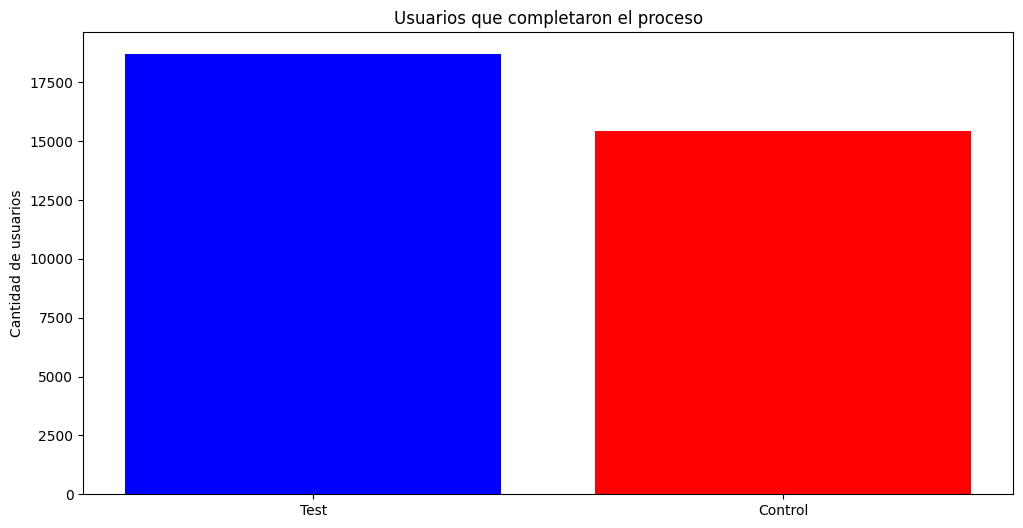

In [25]:
# Graficaas de los resultados obtenidos
# Usuarios que completaron el proceso
plt.figure(figsize=(12, 6))
plt.bar(['Test', 'Control'], [len(usuarios_completaron_test), len(usuarios_completaron_control)], color=['blue', 'red'])
plt.title('Usuarios que completaron el proceso')
plt.ylabel('Cantidad de usuarios')
plt.show()

In [26]:
#Eliminemos los outliers de la columna 'time_diff' para que no afecten el cálculo de la media
q1 = df_final_sorted['time_diff'].quantile(0.25)
q3 = df_final_sorted['time_diff'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_final_sorted = df_final_sorted[(df_final_sorted['time_diff'] > lower_bound) & (df_final_sorted['time_diff'] < upper_bound)]


In [27]:
# Agrupar por client_id y visit_id, y calcular la diferencia de tiempo entre cada paso
df_final_sorted['time_diff'] = df_final_sorted.groupby(['client_id', 'visit_id'])['date_time'].diff().dt.total_seconds() / 60.0

# Filtrar las filas donde time_diff no es nulo
df_time_per_step = df_final_sorted.dropna(subset=['time_diff'])

# Seleccionar las columnas relevantes
df_time_per_step = df_time_per_step[['client_id', 'visit_id', 'process_step', 'time_diff']]

# Mostrar los primeros resultados
df_time_per_step.head()

,client_id,visit_id,process_step,time_diff
255451,555,637149525_38041617439_716659,step_2,0.533333
255450,555,637149525_38041617439_716659,step_3,1.650000
255449,555,637149525_38041617439_716659,confirm,0.333333
9747,647,40369564_40101682850_311847,step_2,0.300000
9746,647,40369564_40101682850_311847,step_3,3.150000


In [28]:
# Filtrar por usuarios en test y eliminar el tiempo de confirmación
df_test = df_final_sorted[(df_final_sorted['Variation'] == 'Test') & (df_final_sorted['process_step'] != 'confirm')]

# Filtrar por usuarios en control y eliminar el tiempo de confirmación
df_control = df_final_sorted[(df_final_sorted['Variation'] == 'Control') & (df_final_sorted['process_step'] != 'confirm')]


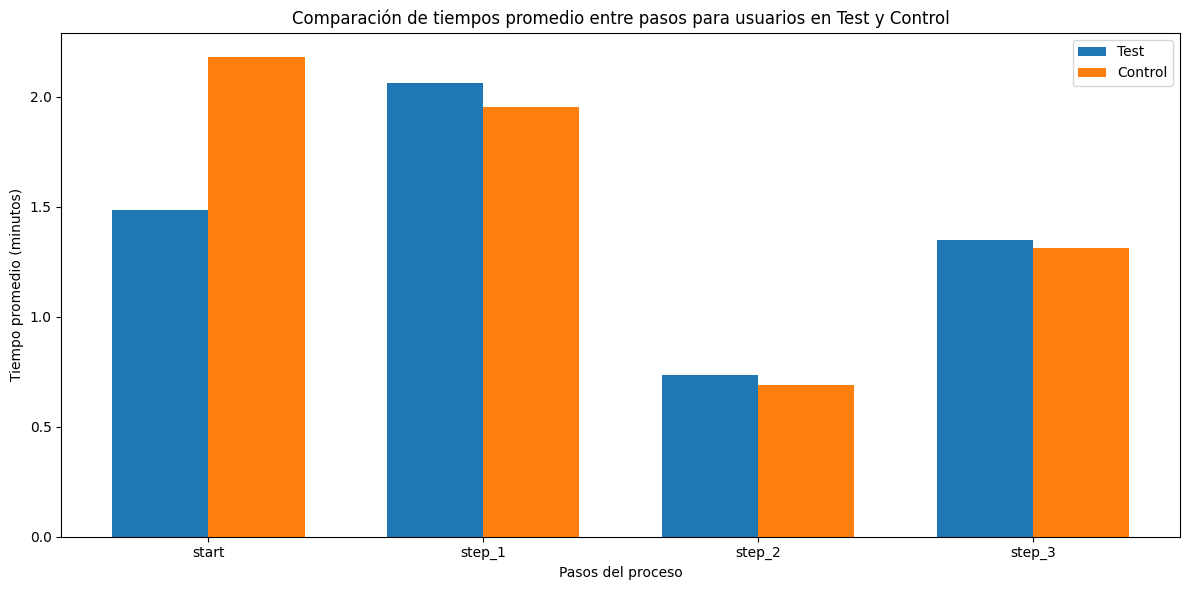

In [29]:
# Calcular el tiempo promedio entre pasos para los usuarios en Test
time_per_step_test = df_test.groupby('process_step')['time_diff'].mean()

# Calcular el tiempo promedio entre pasos para los usuarios en Control
time_per_step_control = df_control.groupby('process_step')['time_diff'].mean()

# Crear una gráfica de barras para comparar los tiempos promedio entre pasos
labels = time_per_step_test.index
test_means = time_per_step_test.values
control_means = time_per_step_control.values

x = np.arange(len(labels))  # la posición de las etiquetas en el eje x
width = 0.35  # el ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, test_means, width, label='Test')
rects2 = ax.bar(x + width/2, control_means, width, label='Control')

# Añadir algunas etiquetas
ax.set_xlabel('Pasos del proceso')
ax.set_ylabel('Tiempo promedio (minutos)')
ax.set_title('Comparación de tiempos promedio entre pasos para usuarios en Test y Control')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [30]:
print("Tiempo promedio entre pasos (Test):")
print(time_per_step_test)
print("\nTiempo promedio entre pasos (Control):")
print(time_per_step_control)


Tiempo promedio entre pasos (Test):
process_step
start     1.483734
step_1    2.063019
step_2    0.736502
step_3    1.346891
Name: time_diff, dtype: float64

Tiempo promedio entre pasos (Control):
process_step
start     2.180694
step_1    1.952783
step_2    0.690743
step_3    1.313744
Name: time_diff, dtype: float64


Tiempo dedicado a cada paso : la duración promedio que los usuarios dedican a cada paso.

Tiempo promedio entre pasos (Test):
process_step
start     2.452503
step_1    0.628393
step_2    0.802194
step_3    1.614183
Name: time_diff, dtype: float64

Tiempo promedio entre pasos (Control):
process_step
start     2.522767
step_1    0.716646
step_2    0.644464
step_3    1.549071
Name: time_diff, dtype: float64

Tasas de error : si hay un paso en el que los usuarios vuelven a un paso anterior, puede indicar confusión o un error. Debe considerar que pasar de un paso posterior a uno anterior es un error.

In [31]:
# Calcular el número de errores para cada usuario

def calcular_errores(grupo):
    errores = 0
    valores_ordenados = sorted(grupo.values)
    for i in range(len(grupo)):
        if grupo.iloc[i] != valores_ordenados[i]:
            errores += 1
    return errores

In [32]:
df_final_sorted['error'] = df_final_sorted.groupby('client_id')['process_step'].apply(calcular_errores)

In [33]:
# Calcular la tasa de error para cada variación
error_rate_test = df_final_sorted[df_final_sorted['Variation'] == 'Test']['error'].mean()
error_rate_control = df_final_sorted[df_final_sorted['Variation'] == 'Control']['error'].mean()

print("Tasa de error (Test):", error_rate_test)
print("Tasa de error (Control):", error_rate_control)

Tasa de error (Test): 3.800632911392405
Tasa de error (Control): 3.754166666666667


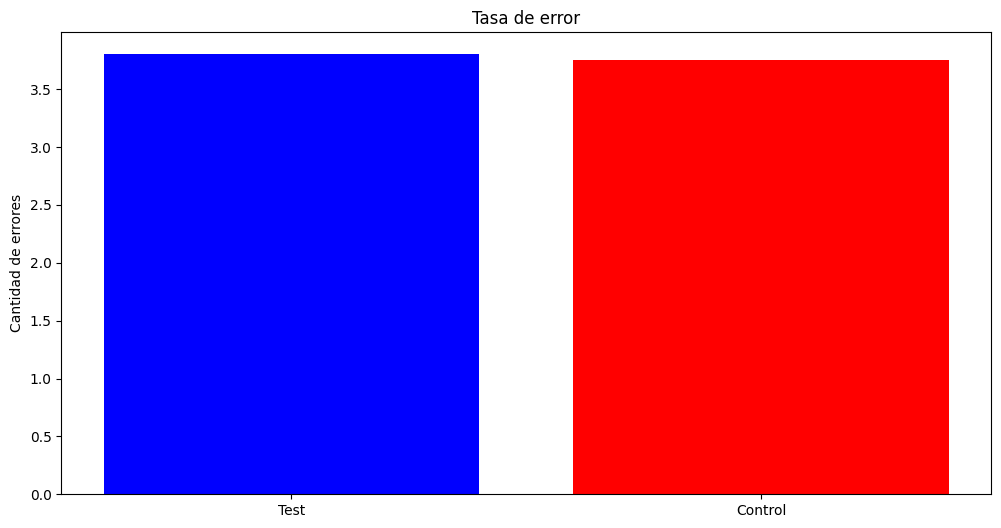

In [34]:
# grafica Tasa de error (Test): 3.800632911392405 y Tasa de error (Control): 3.800632911392405
plt.figure(figsize=(12, 6))
plt.bar(['Test', 'Control'], [error_rate_test, error_rate_control], color=['blue', 'red'])
plt.title('Tasa de error')
plt.ylabel('Cantidad de errores')
plt.show()

Tasa de error (Test): 3.800632911392405
Tasa de error (Control): 3.754166666666667

Resultado del rediseño


En función de los KPI elegidos, ¿cómo se compara el rendimiento del nuevo diseño con el anterior?



In [44]:
# Tasa de finalización
print(f"Tasa de finalización (Test): {completion_rate_test:.2%}")
print(f"Tasa de finalización (Control): {completion_rate_control:.2%}")
print(f"Aumento observado en la tasa de finalización: {aumento_observado:.2%}")
# Tasa de error
print(f"Tasa de error (Test): {error_rate_test:.2f}")
print(f"Tasa de error (Control): {error_rate_control:.2f}")
# Tiempo promedio entre conexiones
print("\nTiempo promedio entre conexiones (Test):")
print(time_diff_test)
print("\nTiempo promedio entre conexiones (Control):")
print(time_diff_control)

Tasa de finalización (Test): 69.30%
Tasa de finalización (Control): 65.59%
Aumento observado en la tasa de finalización: 3.71%
Tasa de error (Test): 3.80
Tasa de error (Control): 3.75

Tiempo promedio entre conexiones (Test):
process_step
confirm    1740.546385
start      4496.282943
step_1       22.331746
step_2        1.853541
step_3       12.315342
Name: time_diff, dtype: float64

Tiempo promedio entre conexiones (Control):
process_step
confirm    1101.288456
start      6117.742410
step_1       30.646361
step_2        0.655704
step_3        9.587008
Name: time_diff, dtype: float64


## Hipótesis 


Tasa de finalización

In [36]:
from scipy.stats import ttest_ind



In [37]:
# definimos la Hipótesis nula y la Hipótesis alternativa
# H0: No hay una diferencia significativa en la tasa de finalización entre los grupos de prueba y de control
# H1: Existe una diferencia significativa en la tasa de finalización entre los grupos de prueba y de control

In [38]:
# Definir las tasas de finalización y el tamaño de las muestras
completion_rate_test = len(usuarios_completaron_test) / len(df_final[df_final['Variation'] == 'Test']['client_id'].unique())
completion_rate_control = len(usuarios_completaron_control) / len(df_final[df_final['Variation'] == 'Control']['client_id'].unique())

n_test = len(df_final[df_final['Variation'] == 'Test']['client_id'].unique())
n_control = len(df_final[df_final['Variation'] == 'Control']['client_id'].unique())
# Realizar la prueba t de dos muestras independientes
t_stat, p_value = ttest_ind(usuarios_completaron_test, usuarios_completaron_control)

# Definir el nivel de significancia
alpha = 0.05

# Imprimir los resultados
print(f"Estadístico t: {t_stat}")
print(f"Valor p: {p_value}")

# Determinar si rechazamos la hipótesis nula
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en la tasa de finalización entre los grupos de prueba y de control.")
else:
    print("No podemos rechazar la hipótesis nula. No hay una diferencia significativa en la tasa de finalización entre los grupos de prueba y de control.")

Estadístico t: -1.3764143769002999
Valor p: 0.16870241210362807
No podemos rechazar la hipótesis nula. No hay una diferencia significativa en la tasa de finalización entre los grupos de prueba y de control.


Tasa de finalización con un umbral de costo-efectividad

In [39]:
# Definir el umbral de aumento mínimo en la tasa de finalización
umbral_aumento = 0.05

# Calcular el aumento observado en la tasa de finalización
aumento_observado = completion_rate_test - completion_rate_control

# Comparar el aumento observado con el umbral
if aumento_observado >= umbral_aumento:
    print(f"El aumento observado en la tasa de finalización ({aumento_observado:.2%}) cumple o supera el umbral del 5%.")
else:
    print(f"El aumento observado en la tasa de finalización ({aumento_observado:.2%}) no cumple con el umbral del 5%.")

El aumento observado en la tasa de finalización (3.71%) no cumple con el umbral del 5%.


Otras Hipótesis

In [ ]:
# H0: Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control
# H1: No hay una diferencia significativa en la edad promedio entre los grupos

In [40]:
# Filtrar las edades de los clientes para cada grupo
edad_test = df_final[df_final['Variation'] == 'Test']['clnt_age'].dropna()
edad_control = df_final[df_final['Variation'] == 'Control']['clnt_age'].dropna()

# Realizar la prueba t de dos muestras independientes
t_stat, p_value = ttest_ind(edad_test, edad_control)

# Imprimir los resultados
print(f"Estadístico t: {t_stat}")
print(f"Valor p: {p_value}")

# Determinar si rechazamos la hipótesis nula
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.")
else:
    print("No podemos rechazar la hipótesis nula. No hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.")

Estadístico t: 7.937665504659508
Valor p: 2.066796718678905e-15
Rechazamos la hipótesis nula. Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.


In [41]:
# Filtrar la permanencia de los clientes para cada grupo
tenure_test = df_final[df_final['Variation'] == 'Test']['clnt_tenure_mnth'].dropna()
tenure_control = df_final[df_final['Variation'] == 'Control']['clnt_tenure_mnth'].dropna()

# Realizar la prueba t de dos muestras independientes
t_stat, p_value = ttest_ind(tenure_test, tenure_control)

# Imprimir los resultados
print(f"Estadístico t: {t_stat}")
print(f"Valor p: {p_value}")

# Determinar si rechazamos la hipótesis nula
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control.")
else:
    print("No podemos rechazar la hipótesis nula. No hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control.")

Estadístico t: 0.5222569822079763
Valor p: 0.6014917765459376
No podemos rechazar la hipótesis nula. No hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control.


In [42]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia para el género y la variación
contingency_table = pd.crosstab(df_final['gendr'], df_final['Variation'])

# Realizar la prueba de chi-cuadrado
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

# Imprimir los resultados
print(f"Estadístico chi-cuadrado: {chi2_stat}")
print(f"Valor p: {p_val}")

# Determinar si rechazamos la hipótesis nula
if p_val < alpha:
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en la participación por género entre los grupos de prueba y de control.")
else:
    print("No podemos rechazar la hipótesis nula. No hay una diferencia significativa en la participación por género entre los grupos de prueba y de control.")

Estadístico chi-cuadrado: 47.84376103857565
Valor p: 4.0818711710883206e-11
Rechazamos la hipótesis nula. Hay una diferencia significativa en la participación por género entre los grupos de prueba y de control.


Evaluación del experimento

¿El experimento estuvo bien estructurado?

In [ ]:
# Una cantidad significativa de usuarios no completaron el proceso en ambos grupos
# La tasa de error es similar en ambos grupos
# No hay una diferencia significativa en la tasa de finalización entre los grupos de prueba y de control
# No hay una diferencia significativa en la edad promedio entre los grupos


# Conclusión
# En general, no hay una diferencia significativa en la participación de los usuarios entre los grupos de prueba y de control.
# Sin embargo, se observa que una cantidad significativa de usuarios no completaron el proceso en ambos grupos, lo que sugiere que puede haber oportunidades para mejorar la experiencia del usuario.

¿Los clientes se dividieron de forma aleatoria y equitativa entre los diseños antiguos y los nuevos?

In [ ]:
# H0: Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control
# h1: No hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control

In [45]:
# Filtrar las edades de los clientes para cada grupo
edad_test = df_final[df_final['Variation'] == 'Test']['clnt_age'].dropna()
edad_control = df_final[df_final['Variation'] == 'Control']['clnt_age'].dropna()

# Realizar la prueba t de dos muestras independientes para las edades
t_stat_edad, p_value_edad = ttest_ind(edad_test, edad_control)

# Imprimir los resultados
print(f"Prueba t para las edades:")
print(f"Estadístico t: {t_stat_edad}")
print(f"Valor p: {p_value_edad}")

# Determinar si rechazamos la hipótesis nula
alpha = 0.05
if p_value_edad < alpha:
    print("Rechazamos la hipótesis nula para las edades. Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.")
else:
    print("No podemos rechazar la hipótesis nula para las edades. No hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.")

Prueba t para las edades:
Estadístico t: 7.937665504659508
Valor p: 2.066796718678905e-15
Rechazamos la hipótesis nula para las edades. Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.


In [ ]:
# H0: Hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control
# H1: No hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control

In [46]:
# Filtrar la permanencia de los clientes para cada grupo
tenure_test = df_final[df_final['Variation'] == 'Test']['clnt_tenure_mnth'].dropna()
tenure_control = df_final[df_final['Variation'] == 'Control']['clnt_tenure_mnth'].dropna()

# Realizar la prueba t de dos muestras independientes para la permanencia
t_stat_tenure, p_value_tenure = ttest_ind(tenure_test, tenure_control)

print(f"\nPrueba t para la permanencia:")
print(f"Estadístico t: {t_stat_tenure}")
print(f"Valor p: {p_value_tenure}")

# Determinar si rechazamos la hipótesis nula
alpha = 0.05

if p_value_tenure < alpha:
    print("Rechazamos la hipótesis nula para la permanencia. Hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control.")
else:
    print("No podemos rechazar la hipótesis nula para la permanencia. No hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control.")


Prueba t para la permanencia:
Estadístico t: 0.5222569822079763
Valor p: 0.6014917765459376
No podemos rechazar la hipótesis nula para la permanencia. No hay una diferencia significativa en la permanencia promedio entre los grupos de prueba y de control.


Prueba t para las edades:
Estadístico t: 7.937665504659508
Valor p: 2.066796718678905e-15

Prueba t para la permanencia:
Estadístico t: 0.5222569822079763
Valor p: 0.6014917765459376
Rechazamos la hipótesis nula para las edades. Hay una diferencia significativa en la edad promedio entre los grupos de prueba y de control.